In [146]:
import numpy
from matplotlib import pyplot
import sys
sys.path.append('../src/')
import densities, conditionals

# Kalman filter

Here we use the Gaussian Toolbox to implement a Kalman filter which has the form

$$
z_{t} = A z_{t-1} + b + \zeta_t \\
x_{t} = C z_t + d + \xi_t,
$$

where $x_t$ are our observations and $z_t$ latent (unobserved) variables. Furthermore, the noise variables are

$$
\zeta_t \sim N(0,Q_z)\\
\xi_t \sim N(0,Q_x).
$$

In [147]:
class KalmanFilter:
    
    def __init__(self, X, A, b, Qz, C, d, Qx):
        """ This is a linear Kalman filter.
        """
        self.Dz, self.Dx = Qz.shape[0], Qx.shape[0]
        self.T = X.shape[0]
        self.X = X
        self.state_density = conditionals.ConditionalGaussianDensity(numpy.array([A]), numpy.array([b]), numpy.array([Qz]))
        self.emission_density = conditionals.ConditionalGaussianDensity(numpy.array([C]), numpy.array([d]), numpy.array([Qx]))
        self.prediction_density = self._setup_density()
        self.filter_density = self._setup_density()
        
    def _setup_density(self):
        Sigma = numpy.tile(numpy.eye(self.Dz)[None], (self.T+1,1,1))
        Lambda = numpy.tile(numpy.eye(self.Dz)[None], (self.T+1,1,1))
        mu = numpy.zeros((self.T + 1, self.Dz))
        ln_det_Sigma = self.Dz * numpy.log(numpy.ones(self.T+1))
        return densities.GaussianDensity(Sigma, mu, Lambda, ln_det_Sigma)
        
        
    def forward_path(self):
        
        for t in range(1, self.T):
            self.prediction(t)
            self.filtering(t)
        
        
    def prediction(self, t: int):
        """ Here the prediction density is calculated.
        
        p(z_t|x_1:t-1) = int p(z_t|z_t-1)p(z_t-1|x_1:t-1) dz_t-1
        """
        # p(z_t-1|x_{1:t-1})
        pre_filter_density = self.filter_density.slice([t-1])
        # p(z_t|x_{1:t-1})
        cur_prediction_density = pre_filter_density.affine_marginal_transformation(self.state_density)
        # Write result into prediction density collection
        self.prediction_density.update([t], cur_prediction_density)
        
        
    def filtering(self, t):
        """ Here the filtering density is calculated.
        
        p(z_t|x_{1:t}) = p(x_t|z_t)p(z_t|x_{1:t-1}) / p(x_t)
        """
        # p(z_t|x_{1:t-1})
        cur_prediction_density = self.prediction_density.slice([t])
        # p(z_t| x_t, x_{1:t-1})
        p_z_given_x = cur_prediction_density.affine_conditional_transformation(self.emission_density)
        # Condition on x_t
        cur_filter_density = p_z_given_x.condition_on_x(self.X[t:t+1])
        # Write result into filter density collection
        self.filter_density.update([t], cur_filter_density)
        
class KalmanSmoother(KalmanFilter):
    
    def __init__(self, X, A, b, Qz, C, d, Qx):
        super().__init__(X, A, b, Qz, C, d, Qx)
        self.smoothing_density = self._setup_density()
        
    def backward_path(self):
        
        last_filter_density = self.filter_density.slice([self.T])
        self.smoothing_density.update([self.T], last_filter_density)
        
        for t in numpy.arange(self.T-1,-1,-1):
            self.smoothing(t)
        
    def smoothing(self, t):
        # p(z_{t} | x_{1:t}) 
        cur_filter_density = self.prediction_density.slice([t])
        # p(z_{t} | z_{t+1}, x_{1:t}) 
        backward_density = cur_filter_density.affine_conditional_transformation(self.state_density)
        # p(z_{t+1} | x_{1:T})
        post_smoothing_density = self.smoothing_density.slice([t+1])
        # p(z_{t} | x_{1:T})
        cur_smoothing_density = post_smoothing_density.affine_marginal_transformation(backward_density)
        # Write result into smoothing density collection
        self.smoothing_density.update([t], cur_smoothing_density)

In [166]:
T = 1000
trange = numpy.arange(T)
Dx = 2
Dz = 2
X = numpy.empty((T,Dx))
X[:,0] = numpy.sin(trange / 20)
X[:,1] = numpy.sin(trange / 10)
noise_x = .1
noise_z = .1
X += noise_x * numpy.random.randn(*X.shape)
Qx = noise_x ** 2 * numpy.eye(Dx)
Qz = noise_z ** 2 * numpy.eye(Dz)
A, b = numpy.eye(Dz), numpy.zeros((Dz,))
C, d = numpy.eye(Dx), numpy.zeros((Dx,))

ks = KalmanSmoother(X, A, b, Qz, C, d, Qx)

In [167]:
ks.forward_path()
ks.backward_path()

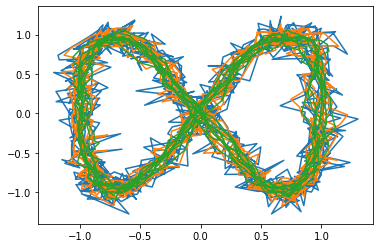

In [168]:
pyplot.plot(X[:,0], X[:,1])
pyplot.plot(ks.filter_density.mu[:,0], ks.filter_density.mu[:,1])
pyplot.plot(ks.smoothing_density.mu[:,0], ks.smoothing_density.mu[:,1])

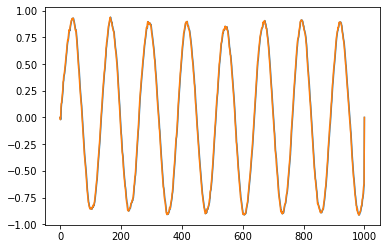

In [104]:
pyplot.plot(kf.prediction_density.mu[:,0])
pyplot.plot(kf.filter_density.mu[:,0])

In [112]:
numpy.arange(100,-1,-1)

array([100,  99,  98,  97,  96,  95,  94,  93,  92,  91,  90,  89,  88,
        87,  86,  85,  84,  83,  82,  81,  80,  79,  78,  77,  76,  75,
        74,  73,  72,  71,  70,  69,  68,  67,  66,  65,  64,  63,  62,
        61,  60,  59,  58,  57,  56,  55,  54,  53,  52,  51,  50,  49,
        48,  47,  46,  45,  44,  43,  42,  41,  40,  39,  38,  37,  36,
        35,  34,  33,  32,  31,  30,  29,  28,  27,  26,  25,  24,  23,
        22,  21,  20,  19,  18,  17,  16,  15,  14,  13,  12,  11,  10,
         9,   8,   7,   6,   5,   4,   3,   2,   1,   0])